In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as  np
from torchvision import utils
import matplotlib.pyplot as plt
import os

### Check for CUDA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Transform the Dataset

In [3]:
path='dataset/Train_dataset_new'
n_channels = 3
n_classes = 10
batch_size = 64
learning_rate = 0.001
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

### Load the dataset using Dataloader

In [4]:
dataset = datasets.ImageFolder(root=path, transform=transform)

# Split the dataset into train, test and validation.
total_dataset_len = len(dataset)
train_dataset_len = int(0.7 * total_dataset_len)
val_dataset_len = int(0.15 * total_dataset_len)
test_dataset_len = total_dataset_len - train_dataset_len - val_dataset_len
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_dataset_len, val_dataset_len, test_dataset_len])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=2, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, num_workers=2, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, num_workers=2, shuffle=False)
print(len(train_loader))

532


## Visualize the Dataset

In [5]:
def show_data(img_grid):
    plt.figure(figsize=(10,10))
    image = img_grid/2 + 0.5
    image_np = image.numpy()
    image_T = np.transpose(image_np, (1, 2, 0)) # Convert (C, H, W) to (H, W, C)
    plt.imshow(image_T)
    plt.show()

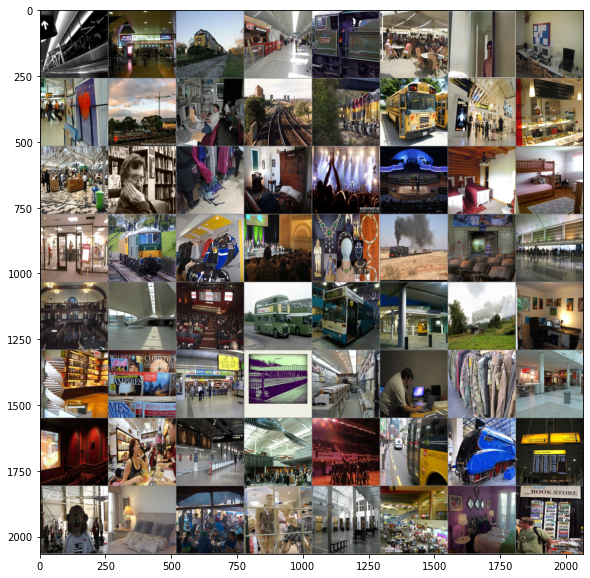

airport_terminal food_court railroad_track airport_terminal railroad_track food_court bedroom computer_room airport_terminal railroad_track computer_room railroad_track railroad_track bus_station-indoor airport_terminal food_court food_court bookstore clothing_store bedroom auditorium auditorium bedroom bedroom bookstore railroad_track clothing_store auditorium jewelry_shop railroad_track auditorium airport_terminal


In [6]:
from torchvision import utils
import matplotlib.pyplot as plt


# Create the iterator for the image
image_load_iter = iter(train_loader)
images, labels = next(image_load_iter)

img_grid = utils.make_grid(images)
show_data(img_grid)

# Print labels
print(' '.join(f'{dataset.classes[labels[j]]}' for j in range(32)))

# Referred from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


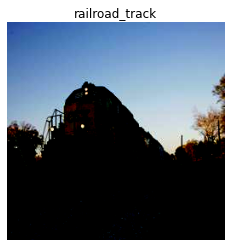

In [7]:
image = images[2]
label = labels[2]
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.axis('off')
plt.title(dataset.classes[label])
plt.show()

## ResNet Architecture

In [7]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):

        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.dropout = nn.Dropout(0.38)

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        x = self.dropout(x)
        return x


In [8]:

class ResNet(nn.Module):
  
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.expansion = 1 # expansion factor is 1 for resnet 18, it is 4 for resnet 50,101 and 152
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False) # Extracts the low level features from input image
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    # Feature map size of 112 * 112
    self.layer1 = self.make_layer(block, layers[0], out_channels=64, stride=1) # Two convolutions with 64 outputs
    self.layer2 = self.make_layer(block, layers[1], out_channels=128, stride=2) # Two convolution with 128 outputs
    self.layer3 = self.make_layer(block, layers[2], out_channels=256, stride=2) # Two convolutions with 256 outputs
    self.layer4 = self.make_layer(block, layers[3], out_channels=512, stride=2) # Two convolution with 512 outputs
    # Feature map size of 7 * 7
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 * self.expansion, num_classes)
# Increasing the filter size will help us to create more deep model and capture complex models
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x,1)
    x = self.fc(x)

    return x

  def make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None # initially identity_downsample is none
    layers = []

    if stride != 1 or self.in_channels != self.expansion * out_channels:
        identity_downsample = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion * out_channels)
        )
        # when above case occurs we create a identity_downsample with 1*1 conv layer to match number of channels

    layers.append(block(self.in_channels, out_channels, identity_downsample, stride)) # append the first residual block with matched dimensions to layers
    self.in_channels = out_channels * self.expansion # update input channels

    for i in range(num_residual_blocks - 1): # append remaining residual blocks
        layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)

### Instantiate the Resetnet Model

In [9]:
def ResNet18(img_channel=3, num_classes=10):
    return ResNet(Block, [2, 2, 2, 2], img_channel, num_classes)

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Define Criteria, Optimizer and Learning Rate Schedular

In [12]:
model = ResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

### Training Loop

In [13]:
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
patience = 4
best_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    training_loss /= len(train_loader)
    train_losses.append(training_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    
    scheduler.step(val_loss)
    
    if val_loss<best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter = 1
    if counter == patience:
        print('early stopping occured')
        torch.save(model.state_dict(), 'resetearly.pth')
        break
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {training_loss:.4f},Train_accuracy : {train_accuracy:.4f}%, Val Loss: {val_loss:.4f}, Val_accuracy: {val_accuracy:.4f}%")
    if val_accuracy > 85:
        savepath = f"/user/paragsha/{epoch+1}.pth"
        torch.save(model.state_dict(), savepath)
    

print('Finished Training')

Epoch [1/50] Train Loss: 1.7049,Train_accuracy : 40.0758%, Val Loss: 1.5854, Val_accuracy: 45.7762%
Epoch [2/50] Train Loss: 1.3301,Train_accuracy : 54.5353%, Val Loss: 1.9142, Val_accuracy: 43.4860%
Epoch [3/50] Train Loss: 1.1339,Train_accuracy : 61.4697%, Val Loss: 1.1600, Val_accuracy: 61.2315%
Epoch [4/50] Train Loss: 1.0322,Train_accuracy : 65.3219%, Val Loss: 1.1991, Val_accuracy: 61.5058%
Epoch [5/50] Train Loss: 0.9586,Train_accuracy : 67.9576%, Val Loss: 1.0681, Val_accuracy: 65.7981%
Epoch [6/50] Train Loss: 0.8958,Train_accuracy : 69.9586%, Val Loss: 1.1094, Val_accuracy: 65.1810%
Epoch [7/50] Train Loss: 0.8602,Train_accuracy : 71.1603%, Val Loss: 0.9679, Val_accuracy: 68.4037%
Epoch [8/50] Train Loss: 0.8307,Train_accuracy : 72.2652%, Val Loss: 0.9436, Val_accuracy: 69.8848%
Epoch [9/50] Train Loss: 0.8029,Train_accuracy : 72.9733%, Val Loss: 0.9003, Val_accuracy: 71.6539%
Epoch [10/50] Train Loss: 0.7808,Train_accuracy : 73.6050%, Val Loss: 0.8707, Val_accuracy: 71.5579%

### Save the Model weights

In [14]:
torch.save(model.state_dict(), 'resnet_final_50.pth')

### Model Testing

In [15]:
def eval_model(model, data_loader, type='validation'):
  correct=0
  total=0
  running_loss = 0.0
  with torch.no_grad():
    model.eval()
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)  
      pred = model(inputs)
      total += labels.size(0)
      loss = criterion(pred, labels.squeeze().long())
      running_loss += loss.item()
      _, predicted = torch.max(pred.data, 1)
      correct += predicted.eq(labels.squeeze().long()).sum().item()
    # print(f'Accuracy of {type},  {100 * correct // total} %')
  test_val_loss = running_loss / len(data_loader)
  test_val_accuracy = 100 * correct / total
  return test_val_loss, test_val_accuracy

In [16]:
test_loss, test_accuracy = eval_model(model, test_loader, type='testing')
print(test_loss, test_accuracy)

0.5398612962218753 82.53358925143954


### Model Evaluation

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_curve, auc
import seaborn as sns

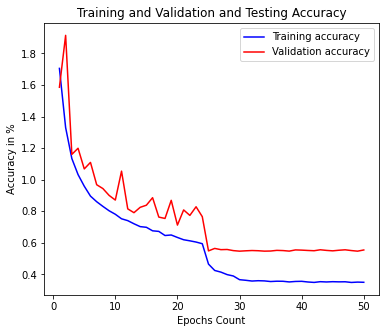

In [18]:
# Plot the training and validation accuracy over time (epochs)
num_of_epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(6, 5))
plt.plot(num_of_epochs, train_losses, 'b', label='Training accuracy')
plt.plot(num_of_epochs, val_losses, 'r', label='Validation accuracy')
# plt.plot(num_of_epochs, test_accuracy_arr, 'g', label='Testing accuracy')
plt.title('Training and Validation and Testing Accuracy')
plt.xlabel('Epochs Count')
plt.ylabel('Accuracy in %')
plt.legend()
plt.show()

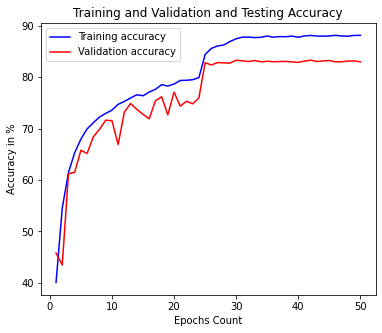

In [20]:
# Plot the training and validation accuracy over time (epochs)
num_of_epochs = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(6, 5))
plt.plot(num_of_epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(num_of_epochs, val_accuracies, 'r', label='Validation accuracy')
# plt.plot(num_of_epochs, test_accuracy_arr, 'g', label='Testing accuracy')
plt.title('Training and Validation and Testing Accuracy')
plt.xlabel('Epochs Count')
plt.ylabel('Accuracy in %')
plt.legend()
plt.show()

In [21]:
y_pred = []
y_pred_softmax = []
y_true = []
y_labels = []
model.eval()
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    pred = model(inputs)
    _, predicted = torch.max(pred.data, 1)
    probs = F.softmax(pred, dim=1)

    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.squeeze().cpu().numpy())
    y_pred_softmax.append(probs.cpu())  
    y_labels.append(labels)

# Confusion metric
y_pred_softmax = torch.cat(y_pred_softmax, dim=0)
y_labels = torch.cat(y_labels, dim=0)
confusionMatrix = confusion_matrix(y_true, y_pred)


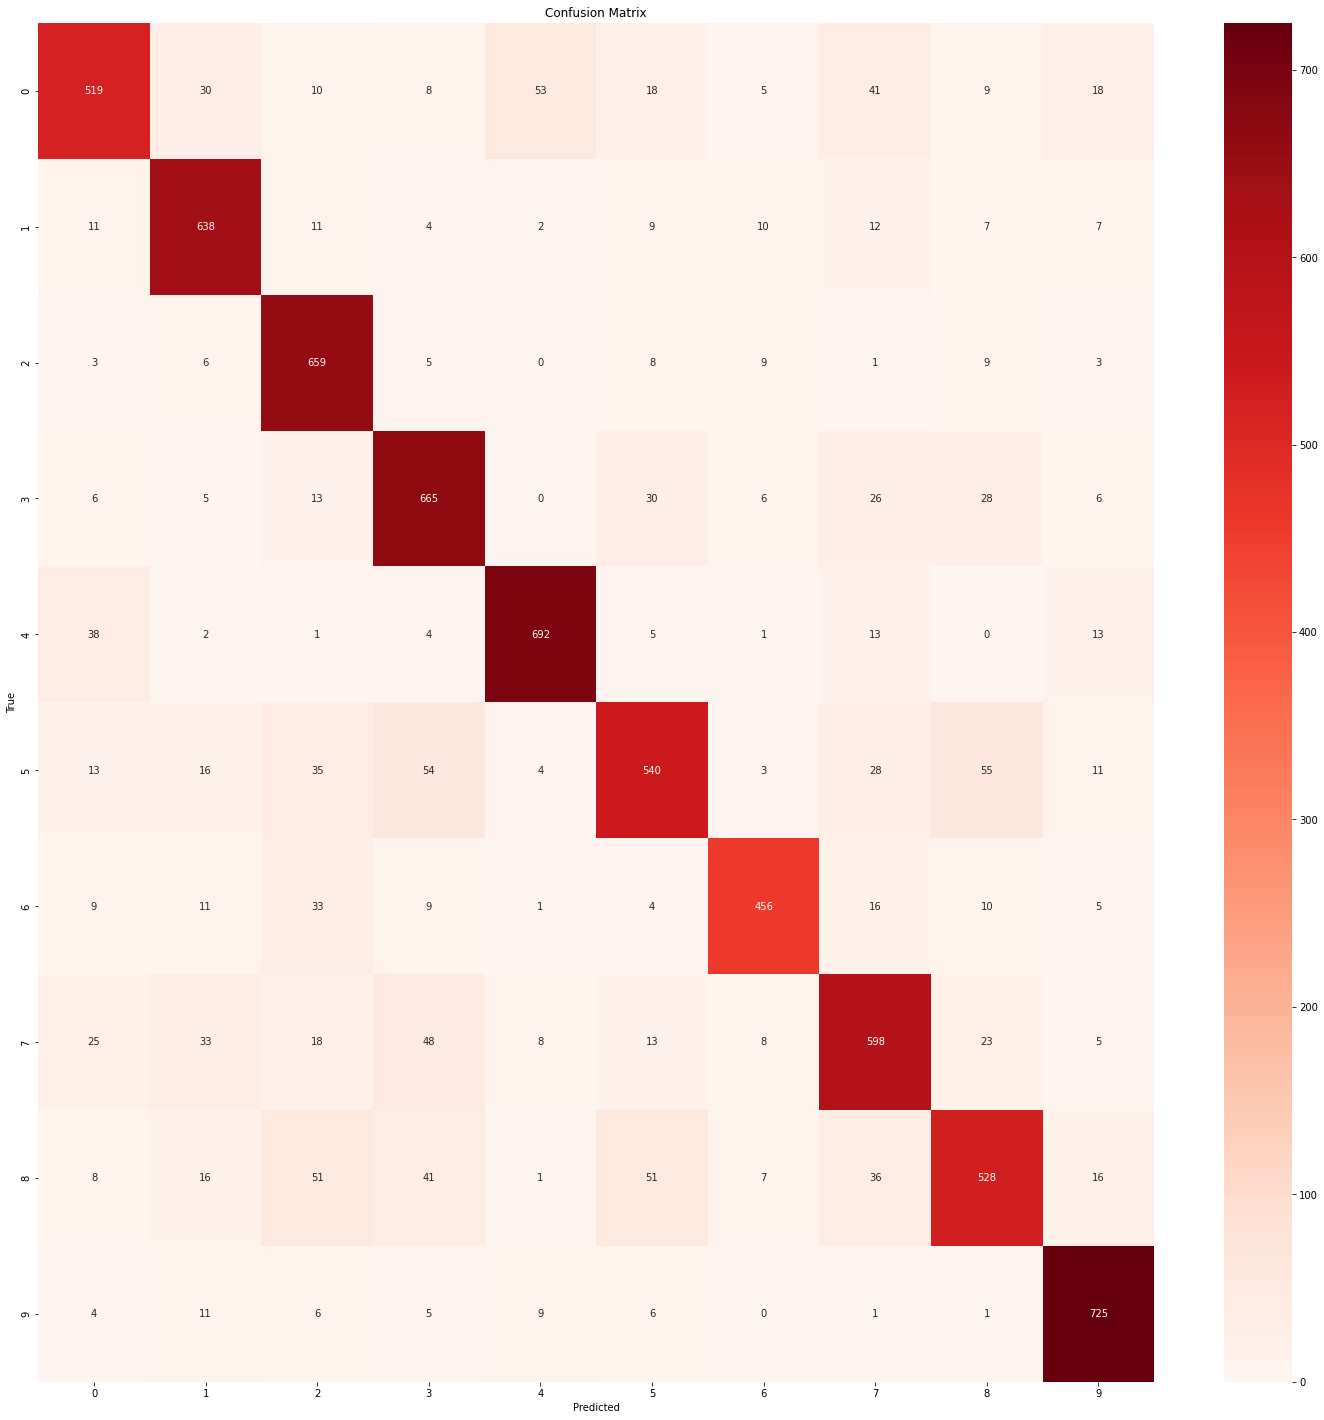

In [22]:
# Generate confusion Matrix using heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Print precision, recall, f1_score using scikit learn
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1_score:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Precision: 0.83
Recall: 0.83
F1-score: 0.82
Accuracy: 0.83
